In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_auc_score
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Part 1

[42.55939457850009, 44.9475838967806, 92.30196637925687, 36.00272935922089, 68.71161838595621, 88.58631598536071, 48.99820110414987, 56.65281310092426, 0.0]
['Feature A', 'Feature B', 'Feature C', 'Feature D', 'Feature E', 'Feature F', 'Feature G', 'Feature H', 'Target']


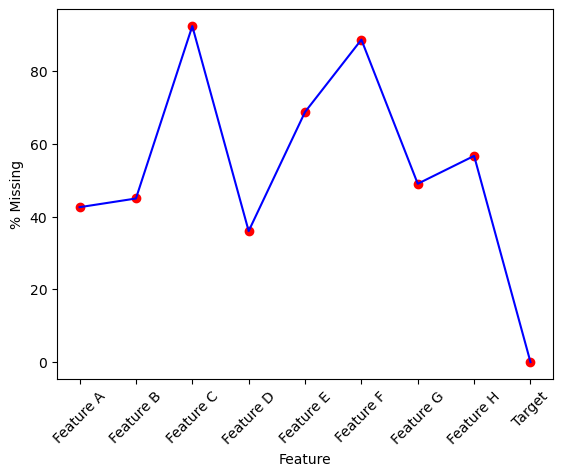

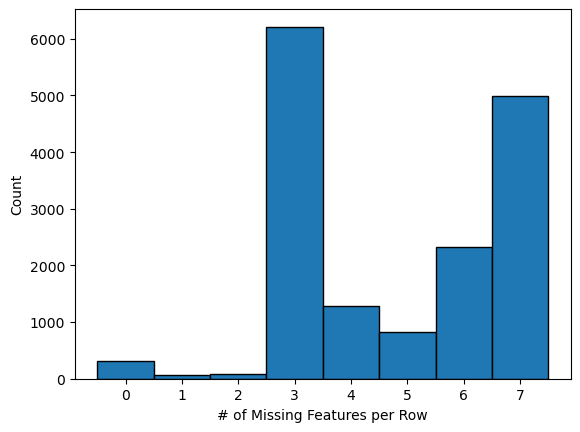

In [2]:
true_records = pd.read_csv('true_records.csv')
false_records = pd.read_csv('false_records.csv')
merged = pd.concat([true_records, false_records], axis=0, ignore_index=True)

missing_percent = []
x = []
for i in merged.columns:
    p = (merged.isna().sum()[i] / merged[i].size)*100
    missing_percent.append(p)
    x.append(i)
print(missing_percent)
print(x)

plt.plot(x, missing_percent, label='Line', linestyle='-', color='blue')
plt.scatter(x, missing_percent, color='red', label='Points')
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('% Missing')
plt.show()

x_row = merged.isna().sum(axis=1).index.values
missing_features_per_row = merged.isna().sum(axis=1).values

n, bins, patches = plt.hist(missing_features_per_row, bins=range(min(missing_features_per_row), max(missing_features_per_row)+1), edgecolor='black')

bin_centers = 0.5 * (bins[:-1] + bins[1:])
plt.xticks(bin_centers, labels=[f'{round(x,2)}' for x in bins[:-1]])

plt.xlabel('# of Missing Features per Row')
plt.ylabel('Count')
plt.show()

## Part 2

In [3]:
column_means = merged.mean()
merged_filled_na = merged.fillna(column_means)
X_train_filled, X_test_filled, y_train_filled, y_test_filled = train_test_split(merged_filled_na.iloc[:,:-1], 
                                                                                merged_filled_na.iloc[:,-1], test_size=0.2, random_state=0)
X_train_unfilled, X_test_unfilled, y_train_unfilled, y_test_unfilled = train_test_split(merged.iloc[:,:-1], 
                                                                                        merged.iloc[:,-1], test_size=0.2, random_state=0)


## Part 3

In [4]:
# scaling
scaler = StandardScaler()
X_train_filled_scaled = scaler.fit_transform(X_train_filled)
X_test_filled_scaled = scaler.transform(X_test_filled)

### A: Logistic Regression

In [5]:
start_time = time.time()
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_filled_scaled, y_train_filled)
logreg_time = time.time() - start_time

print(f"Logistic Regression fitting time: {logreg_time:.4f} seconds")

Logistic Regression fitting time: 0.2837 seconds


### B: Support Vector Classifier

In [6]:
start_time = time.time()
svc = SVC(probability=True)
svc.fit(X_train_filled_scaled, y_train_filled)
svc_time = time.time() - start_time

print(f"Support Vector Classifier fitting time: {svc_time:.4f} seconds")

Support Vector Classifier fitting time: 25.3713 seconds


### C: Random Forest Classifier

In [7]:
start_time = time.time()
rf = RandomForestClassifier()
rf.fit(X_train_filled, y_train_filled)
rf_time = time.time() - start_time

print(f"Random Forest fitting time: {rf_time:.4f} seconds")

Random Forest fitting time: 1.1217 seconds


### D: Boosting Tree Classifier

In [8]:
start_time = time.time()
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train_filled, y_train_filled)
lgbm_time_filled = time.time() - start_time

print(f"LightGBM (filled data) fitting time: {lgbm_time_filled:.4f} seconds")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6736, number of negative: 6160
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1001
[LightGBM] [Info] Number of data points in the train set: 12896, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.522333 -> initscore=0.089389
[LightGBM] [Info] Start training from score 0.089389
LightGBM (filled data) fitting time: 0.4186 seconds


### E: Boosting Tree Classifier on unfilled data

In [9]:
start_time = time.time()
lgbm_unfilled = lgb.LGBMClassifier()
lgbm_unfilled.fit(X_train_unfilled, y_train_unfilled)
lgbm_time_unfilled = time.time() - start_time

print(f"LightGBM (unfilled data) fitting time: {lgbm_time_unfilled:.4f} seconds")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6736, number of negative: 6160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1001
[LightGBM] [Info] Number of data points in the train set: 12896, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.522333 -> initscore=0.089389
[LightGBM] [Info] Start training from score 0.089389
LightGBM (unfilled data) fitting time: 0.2528 seconds


## Part 4

In [10]:
class FFN(nn.Module): 
    def __init__(self, in_features, w=64, num_hidden_layers = 6):
        super().__init__()
        self.in_layer = nn.Linear(in_features, w)
        self.hidden_layer = {n: nn.Linear(w,w) for n in range(num_hidden_layers)}
        self.out_layer = nn.Linear(w, 1)
        
    def forward(self, x):
        y = self.in_layer(x)
        y = nn.ReLU()(y)
        for l in self.hidden_layer:
            y = self.hidden_layer[l](y)
            y = nn.ReLU()(y)
        y = self.out_layer(y)
        y = nn.Sigmoid()(y)
        return y

net = FFN(8, w=48, num_hidden_layers=6)
optimizer = torch.optim.Adam(net.parameters())
n_epochs = 400

x_train_tensor = torch.tensor(X_train_filled.values).float()
y_train_tensor = torch.tensor(y_train_filled.values).float()

start_time = time.time()
for e in range(n_epochs):
    optimizer.zero_grad()
    y_pred = net(x_train_tensor).squeeze(1)
    loss = nn.BCELoss()(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()
nn_time = time.time() - start_time
print(f"NN fitting time: {nn_time:.4f} seconds")

NN fitting time: 6.3396 seconds


## Part 5
### A: F1 Score

In [11]:
# logistic
y_pred_logreg = logreg.predict(X_test_filled_scaled)
f1_logreg = f1_score(y_test_filled, y_pred_logreg)
print(f"Logistic F1: {f1_logreg}")

# svc
y_pred_svc = svc.predict(X_test_filled_scaled)
f1_svc = f1_score(y_test_filled, y_pred_svc)
print(f"SVC F1: {f1_svc}")

# random forest
y_pred_rf = rf.predict(X_test_filled)
f1_rf = f1_score(y_test_filled, y_pred_rf)
print(f"Random Forest F1: {f1_rf}")

# boosting tree classifier filled
y_pred_lgbm_filled = lgbm.predict(X_test_filled)
f1_lgbm_filled = f1_score(y_test_filled, y_pred_lgbm_filled)
print(f"BTC Filled F1: {f1_lgbm_filled}")

# boosting tree classifier unfilled
y_pred_lgbm_unfilled = lgbm_unfilled.predict(X_test_unfilled)
f1_lgbm_unfilled = f1_score(y_test_unfilled, y_pred_lgbm_unfilled)
print(f"BTC Unfilled F1: {f1_lgbm_unfilled}")

# neural net
x_test_tensor = torch.tensor(X_test_filled.values).float()
y_pred_nn = net(x_test_tensor)
y_pred_nn_numpy = y_pred_nn.squeeze(1).detach().numpy()
f1_nn = f1_score(y_test_filled, y_pred_nn_numpy > 0.5)
print(f"NN F1: {f1_nn} seconds")

Logistic F1: 0.677799069258144
SVC F1: 0.7758683729433273
Random Forest F1: 0.8356867779204108
BTC Filled F1: 0.8288659793814432
BTC Unfilled F1: 0.8338451040600479
NN F1: 0.6793673616103523 seconds


### B:Log loss

In [12]:
# logistic
y_pred_proba_logreg = logreg.predict_proba(X_test_filled_scaled)[:, 1]
log_loss_logreg = log_loss(y_test_filled, y_pred_proba_logreg)
print(f"Logistic Logloss: {log_loss_logreg}")

# svc
y_pred_proba_svc = svc.predict_proba(X_test_filled_scaled)[:, 1] 
log_loss_svc = log_loss(y_test_filled, y_pred_proba_svc)
print(f"SVC Logloss: {log_loss_svc}")

# random forest
y_pred_proba_rf = rf.predict_proba(X_test_filled)[:, 1]
log_loss_rf = log_loss(y_test_filled, y_pred_proba_rf)
print(f"Random Forest: {log_loss_rf}")

# boosting tree classifier filled
y_pred_proba_lgbm_filled = lgbm.predict_proba(X_test_filled)[:, 1]
log_loss_lgbm_filled = log_loss(y_test_filled, y_pred_proba_lgbm_filled)
print(f"BTC Filled Logloss: {log_loss_lgbm_filled}")

# boosting tree classifier unfilled
y_pred_proba_lgbm_unfilled = lgbm_unfilled.predict_proba(X_test_unfilled)[:, 1]
log_loss_lgbm_unfilled = log_loss(y_test_unfilled, y_pred_proba_lgbm_unfilled)
print(f"BTC Unfilled Logloss: {log_loss_lgbm_unfilled}")

# neural net
log_loss_nn = log_loss(y_test_filled, y_pred_nn_numpy)
print(f"NN Logloss: {log_loss_nn}")

Logistic Logloss: 0.5727877872318495
SVC Logloss: 0.4197519637563408
Random Forest: 0.5855642044803548
BTC Filled Logloss: 0.31717362442507996
BTC Unfilled Logloss: 0.3114182515105075
NN Logloss: 0.5627020166944915


### C: ROC Curve

In [13]:
# logistic
roc_auc_logreg = roc_auc_score(y_test_filled, y_pred_proba_logreg)
print(f"Logistic Area under ROC: {roc_auc_logreg}")

# svc
roc_auc_svc = roc_auc_score(y_test_filled, y_pred_proba_svc)
print(f"SVC Area under ROC: {roc_auc_svc}")

# random forest
roc_auc_rf = roc_auc_score(y_test_filled, y_pred_proba_rf)
print(f"Random Forest Area under ROC: {roc_auc_rf}")

# boosting tree classifier filled
roc_auc_lgbm_filled = roc_auc_score(y_test_filled, y_pred_proba_lgbm_filled)
print(f"BTC Filled Area under ROC: {roc_auc_lgbm_filled}")

# boosting tree classifier unfilled
roc_auc_lgbm_unfilled = roc_auc_score(y_test_unfilled, y_pred_proba_lgbm_unfilled)
print(f"BTC Unfilled Area under ROC: {roc_auc_lgbm_unfilled}")

# neural net
roc_auc_nn = roc_auc_score(y_test_filled, y_pred_nn_numpy)
print(f"NN Area under ROC: {roc_auc_nn}")

Logistic Area under ROC: 0.7648047634322497
SVC Area under ROC: 0.8657215418308029
Random Forest Area under ROC: 0.9256182946444849
BTC Filled Area under ROC: 0.9243077046155077
BTC Unfilled Area under ROC: 0.928350245040912
NN Area under ROC: 0.7447368704456275


## Part 6

In [14]:
# scaling
scaler = StandardScaler()
X_train_filled_scaled = scaler.fit_transform(X_train_filled)
X_test_filled_scaled = scaler.transform(X_test_filled)

### Calculating F1 Score and Logloss Again

In [17]:
warnings.filterwarnings("ignore", category=UserWarning)
test_missing_features_per_row = X_test_unfilled.isna().sum(axis=1).values

num_missing_features = []
f1_log = []
f1_svc_list = []
f1_rf_list = []
f1_btc_filled = []
f1_btc_unfilled = []
f1_nn = []
ll_log = []
ll_svc = []
ll_rf = []
ll_btc_filled = []
ll_btc_unfilled = []
ll_nn = []
xr = []

for i in np.unique(X_train_unfilled.isna().sum(axis=1).values)[0:]:
    xr.append(i)
    test_indicies = np.where(test_missing_features_per_row == i)
    X_test_filled_scaled_temp = X_test_filled_scaled[test_indicies[0]]
    X_test_unfilled_temp = X_test_unfilled.iloc[test_indicies[0]]
    y_test_unfilled_temp = y_test_unfilled.iloc[test_indicies[0]]
    y_test_filled_temp = y_test_filled.iloc[test_indicies[0]]
    
    # logistic
    y_pred_logreg = logreg.predict(X_test_filled_scaled_temp)
    f1_logreg = f1_score(y_test_filled_temp, y_pred_logreg)
    y_pred_proba_logreg = logreg.predict_proba(X_test_filled_scaled_temp)[:, 1]
    log_loss_logreg = log_loss(y_test_filled_temp, y_pred_proba_logreg, labels=[0,1])
    f1_log.append(f1_logreg)
    ll_log.append(log_loss_logreg)

    # svc
    y_pred_svc = svc.predict(X_test_filled_scaled_temp)
    f1_svc = f1_score(y_test_filled_temp, y_pred_svc)
    y_pred_proba_svc = svc.predict_proba(X_test_filled_scaled_temp)[:, 1] 
    log_loss_svc = log_loss(y_test_filled_temp, y_pred_proba_svc, labels=[0,1])
    f1_svc_list.append(f1_svc)
    ll_svc.append(log_loss_svc)

    # random forest
    y_pred_rf = rf.predict(X_test_filled_scaled_temp)
    f1_rf = f1_score(y_test_filled_temp, y_pred_rf)
    y_pred_proba_rf = rf.predict_proba(X_test_filled_scaled_temp)[:, 1]
    log_loss_rf = log_loss(y_test_filled_temp, y_pred_proba_rf, labels=[0,1])
    f1_rf_list.append(f1_rf)
    ll_rf.append(log_loss_rf)
    
    # boosting tree classifier filled
    y_pred_lgbm_filled = lgbm.predict(X_test_filled_scaled_temp)
    f1_lgbm_filled = f1_score(y_test_filled_temp, y_pred_lgbm_filled)
    y_pred_proba_lgbm_filled = lgbm.predict_proba(X_test_filled_scaled_temp)[:, 1]
    log_loss_lgbm_filled = log_loss(y_test_filled_temp, y_pred_proba_lgbm_filled, labels=[0,1])
    f1_btc_filled.append(f1_lgbm_filled)
    ll_btc_filled.append(log_loss_lgbm_filled)
    
    # boosting tree classifier unfilled
    y_pred_lgbm_unfilled = lgbm_unfilled.predict(X_test_unfilled_temp)
    f1_lgbm_unfilled = f1_score(y_test_unfilled_temp, y_pred_lgbm_unfilled)
    y_pred_proba_lgbm_unfilled = lgbm_unfilled.predict_proba(X_test_unfilled_temp)[:, 1]
    log_loss_lgbm_unfilled = log_loss(y_test_unfilled_temp, y_pred_proba_lgbm_unfilled, labels=[0,1])
    f1_btc_unfilled.append(f1_lgbm_unfilled)
    ll_btc_unfilled.append(log_loss_lgbm_unfilled)
    
    # neural net
    x_test_tensor = torch.tensor(X_test_filled_scaled_temp).float()
    y_pred_nn = net(x_test_tensor)
    y_pred_nn_numpy = y_pred_nn.squeeze(1).detach().numpy()
    f1_neural_net = f1_score(y_test_filled_temp, y_pred_nn_numpy > 0.5)
    nn_log_loss = log_loss(y_test_filled_temp, y_pred_nn_numpy, labels=[0,1])
    f1_nn.append(f1_neural_net)
    ll_nn.append(nn_log_loss)

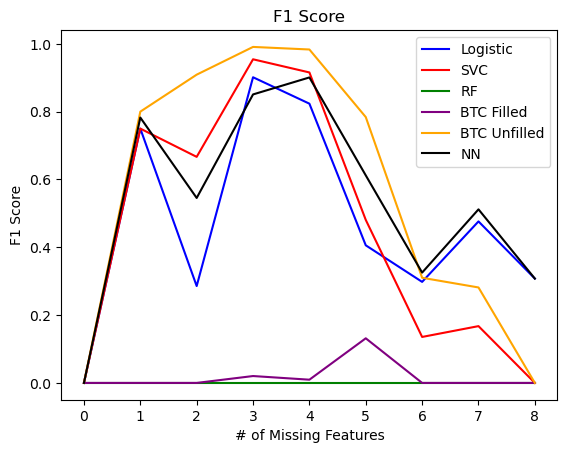

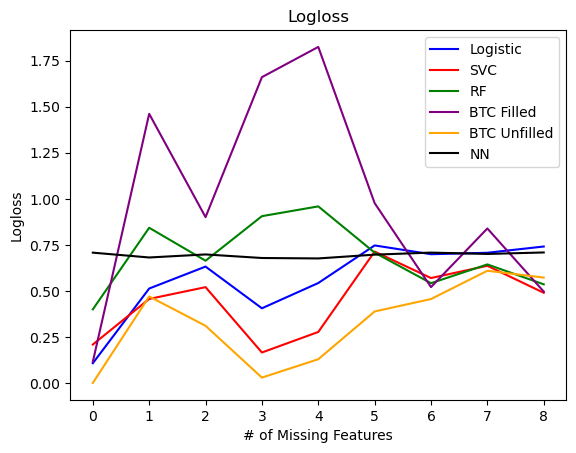

In [18]:
plt.plot(xr, f1_log, color='blue', label='Logistic')
plt.plot(xr, f1_svc_list, color='red', label='SVC')
plt.plot(xr, f1_rf_list, color='green', label='RF')
plt.plot(xr, f1_btc_filled, color='purple', label='BTC Filled')
plt.plot(xr, f1_btc_unfilled, color='orange', label='BTC Unfilled')
plt.plot(xr, f1_nn, color='black', label='NN')
plt.title('F1 Score')
plt.xlabel('# of Missing Features')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

plt.plot(xr, ll_log, color='blue', label='Logistic')
plt.plot(xr, ll_svc, color='red', label='SVC')
plt.plot(xr, ll_rf, color='green', label='RF')
plt.plot(xr, ll_btc_filled, color='purple', label='BTC Filled')
plt.plot(xr, ll_btc_unfilled, color='orange', label='BTC Unfilled')
plt.plot(xr, ll_nn, color='black', label='NN')
plt.title('Logloss')
plt.xlabel('# of Missing Features')
plt.ylabel('Logloss')
plt.legend()
plt.show()


I interpret these values as for some models, having/using missing features improves the model performance, as an example - for boosting tree classifiers filled, the F1 score for 5 missing features is higher than that of 3 or even 1 missing feature. In addition, the logloss for 6 or 8 missing features is lower than the logloss for 1 missing feature. A similar patter is also noticed for BTC unfilled as well.    

However, the above pattern is not true for the logistic or SVC model where performace becomes worse as number of missing features increases. 

## Part 7

Based on the above results, I would choose the boosting tree classifier unfilled because accross all # of missing features it does very well compared to the other models in terms of having a high average F1 score and low average log loss. 

Some of the other models do better on F1 score or logloss for particular # of missing features, however, overall, BTC unfilled did better. 